In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxopt
import yfinance as yf
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import datetime

In [176]:
def getStockPrice(s, lastYearMore = False):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)
    raw = yf.download(s, start=start_date, end=end_date)
    p = raw["Adj Close"].dropna(how="all")
    # Add cash into the dataset

    # Copy last year data to achieve 1.5x weight
    # Add weights
    if lastYearMore:
        recent_year = end_date - pd.DateOffset(years=1)
        recent_data = p[p.index >= recent_year]
        weighted_prices = pd.concat([p, recent_data, recent_data * 0.5])
        return weighted_prices.dropna()

    return p.dropna()

def predict(prices, model="RF"):
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    # For each stock, create a Random Forest model and predict the price for next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    predicted_changes = pd.Series(index=prices.columns)
    confidence_values = pd.Series(index=prices.columns)
    for s in prices.columns:
        X = np.array(range(len(prices[s]))).reshape(-1, 1)
        y = prices[s].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        else:
            raise ValueError(f"Unknown model: {model}")

        estimator.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[s]), len(prices[s]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = estimator.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            estimator.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[s] = y
        change = (y[-1] - y[-21]) / y[-21]
        predicted_changes[s] = change
    for s in prices.columns:
        confidence_values[s] = (predicted_changes[s] - predicted_changes.min()) / (predicted_changes.max() - predicted_changes.min())
    predicted_only = predicted_prices.tail(20)
    return predicted_prices, predicted_changes, confidence_values, predicted_only


In [177]:
def predict_ridge(s, factor_returns, future_factors, model='ridge'):
    future_returns = {}
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)

    for stock in stocks:
        stock_data = yf.download(stock, start=start_date, end=end_date)
        stock_returns = ((stock_data['Close'] / stock_data['Close'].shift(1))-1).dropna().tolist()

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        elif model == 'ridge':
            estimator = Ridge()
        else:
            raise ValueError(f"Unknown model: {model}")

        estimator.fit(factor_returns, stock_returns)
        stock_future = estimator.predict(future_factors)
        # print(f"Coefficients for {stock} stock: ", single_index_reg.coef_)

        future_returns[stock] = stock_future

    future_returns = pd.DataFrame(future_returns)
    return future_returns

In [178]:
stocks = ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'SEDG', 'CVX', 'MCD', 'AAPL', 'GS', 'CI', 'NVDA']
stock_prices = getStockPrice(stocks, lastYearMore=True)
index = ['^SPX']
index_price = getStockPrice(index)
factor = ['^SPX', '^IXIC', '^DJI', '^RUT']
factor_price = getStockPrice(factor)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed


In [179]:
p_price, p_change, p_confidence, p_only = predict(factor_price, model="RF")
factor_returns = factor_price.pct_change().dropna()
sp_returns = factor_returns['^SPX']
nasdaq_returns = factor_returns['^IXIC']
dow_returns = factor_returns['^DJI']
russell_returns = factor_returns['^RUT']
sp_future = p_only.pct_change().dropna()['^SPX']
nasdaq_future = p_only.pct_change().dropna()['^IXIC']
dow_future = p_only.pct_change().dropna()['^DJI']
russell_future = p_only.pct_change().dropna()['^RUT']

In [180]:
GDP_prices = {
        2018: 59607,
        2019: 60698,
        2020: 58453,
        2021: 61855,
        2022: 62551,
        2023: 63451
    }
values = list(GDP_prices.values())
values_array = [[value] for value in values]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(values_array)
scaled_values = scaled_values.flatten()
scaled_GDP_prices = {year: scaled_value for year, scaled_value in zip(GDP_prices.keys(), scaled_values)}
print(scaled_GDP_prices)

{2018: -0.8731875620129659, 2019: -0.23617811356352036, 2020: -1.5469812407578423, 2021: 0.43936719519542417, 2022: 0.8457453584592317, 2023: 1.3712343626796726}


In [181]:
for index, row in factor_returns.iterrows():
    # Extract the year from the date
    year = index.year

    # Fill the 'GDP' column with the corresponding GDP price based on the year
    factor_returns.at[index, 'GDP'] = scaled_GDP_prices.get(year)

In [182]:
future_factors = {'^DJI': dow_future, '^IXIC': nasdaq_future, '^RUT': russell_future, '^SPX': sp_future, 'GDP': [scaled_GDP_prices.get(2023)]*19}
future_factors = pd.DataFrame(future_factors)

In [183]:
future_returns = predict_ridge(stocks, factor_returns, future_factors)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [184]:
S = risk_models.sample_cov(future_returns)
print(S)

              PFE       COST       AMZN      GOOGL        MRK       TSLA  \
PFE    106.116471  22.955173  51.022386  27.622586  15.359142  83.166090   
COST    22.955173   5.481046  10.151866   6.793520   3.593675  17.929641   
AMZN    51.022386  10.151866  26.099891  11.873263   6.921768  40.107430   
GOOGL   27.622586   6.793520  11.873263   8.490844   4.428152  21.548677   
MRK     15.359142   3.593675   6.921768   4.428152   2.366175  12.006352   
TSLA    83.166090  17.929641  40.107430  21.548677  12.006352  65.195428   
LMT     19.106623   4.518071   8.529705   5.584498   2.968753  14.929480   
BSX     19.841850   4.671217   8.889351   5.767367   3.071767  15.504056   
HSBC    15.467206   3.596960   7.006066   4.425401   2.371308  12.090933   
MSFT    25.388737   6.135348  11.101013   7.630478   4.012980  19.820768   
SEDG    47.109638   8.800639  25.118638  10.045686   6.088503  37.125363   
CVX     19.111382   4.495797   8.569816   5.549771   2.957258  14.933427   
MCD     24.1

In [185]:
ef = EfficientFrontier(future_returns.mean(), S)
ef.add_objective(objective_functions.L2_reg)
ef.add_constraint(lambda w: w <= 0.10)
ef.add_constraint(lambda w: w >= 0.05)
ef.max_sharpe(risk_free_rate=0.0)
weights = ef.clean_weights()
weights

/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('PFE', 0.05),
             ('COST', 0.05),
             ('AMZN', 0.05),
             ('GOOGL', 0.05),
             ('MRK', 0.05),
             ('TSLA', 0.05),
             ('LMT', 0.05),
             ('BSX', 0.05),
             ('HSBC', 0.1),
             ('MSFT', 0.05),
             ('SEDG', 0.05),
             ('CVX', 0.1),
             ('MCD', 0.05),
             ('AAPL', 0.05),
             ('GS', 0.05),
             ('CI', 0.05),
             ('NVDA', 0.1)])

In [186]:
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=False)
sharpe_ratio

/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


0.00026267456802275054

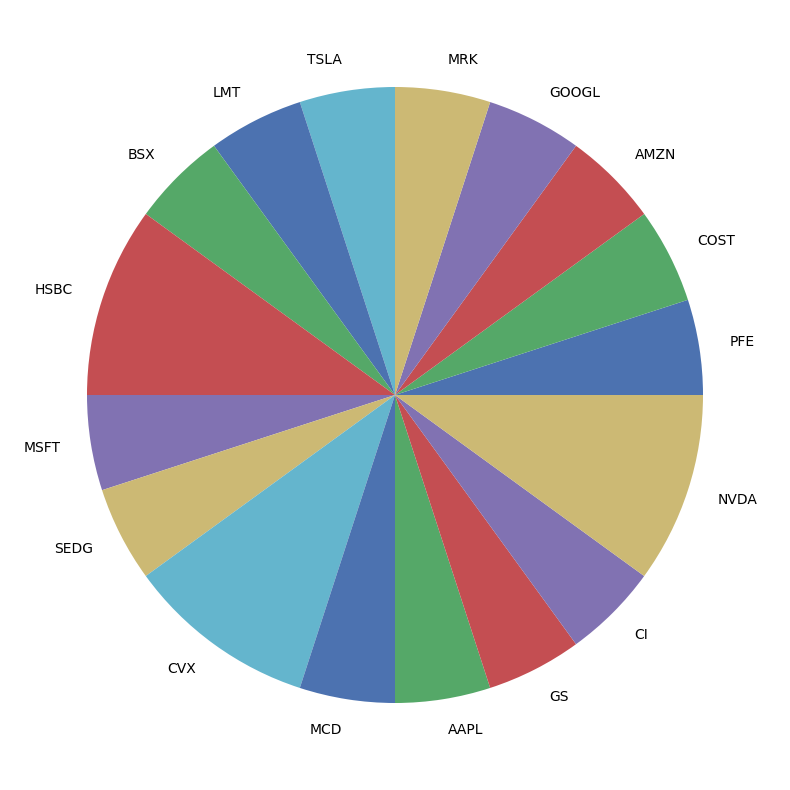

In [187]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [188]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, stock_prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $6.93


/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'PFE': 10,
 'COST': 15,
 'AMZN': 37,
 'GOOGL': 7,
 'MRK': 4,
 'TSLA': 13,
 'LMT': 17,
 'BSX': 6,
 'HSBC': 101,
 'MSFT': 4,
 'SEDG': 7,
 'CVX': 35,
 'MCD': 6,
 'AAPL': 5,
 'GS': 55,
 'CI': 7,
 'NVDA': 15}